1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [22]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import xgboost as xgb, catboost as catb
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix


In [2]:
def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [3]:
def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)
    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [15]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

In [13]:
def evaluation_sec(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
 #   ll = log_loss(y_true=y_true, y_pred=y_prob)
 #   roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
 #   print('Log Loss: {}'.format(ll)) 
 #   print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1#, ll, roc_auc

In [3]:
# x_train = pd.read_csv('./dataset/x_train.csv', sep=';', encoding='utf-8')
# y_train = pd.read_csv('./dataset/y_train.csv', sep=';', header=None, encoding='utf-8')
# y_train = y_train[0]
# x_test = pd.read_csv('./dataset/x_test.csv', sep=';', encoding='utf-8')
# y_test = pd.read_csv('./dataset/y_test.csv', sep=';', header=None, encoding='utf-8')
# y_test = y_test[0]

In [7]:
# Загружаем обработанные данные
df = pd.read_csv('./dataset/processed_train.csv', sep=';', encoding='utf-8')
X = df.drop(['is_churned'], axis=1).columns
y = df['is_churned']

In [7]:
# Нормализуем данные
X_mm = MinMaxScaler().fit_transform(X)

In [14]:
# Разбиваем данные и делаем балансировку тренировочного набора
x_train, x_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)
smote_enn = SMOTEENN(random_state=42)
x_train_balanced, y_train_balanced = smote_enn.fit_resample(x_train, y_train)

In [18]:
# Сохраняем то, что получилось, ато долго обрабатывается
pd.DataFrame(x_train).to_csv('./dataset/x_train_HW.csv', sep=';', index=False)
pd.DataFrame(x_test).to_csv('./dataset/x_test_HW.csv', sep=';', index=False)
pd.DataFrame(y_train).to_csv('./dataset/y_train_HW.csv', sep=';', index=False)
pd.DataFrame(y_test).to_csv('./dataset/y_test_HW.csv', sep=';', index=False)
pd.DataFrame(x_train_balanced).to_csv('./dataset/x_train_balanced_HW.csv', sep=';', index=False)
pd.DataFrame(y_train_balanced).to_csv('./dataset/y_train_balanced_HW.csv', sep=';', index=False)

In [5]:
# Загужаем наборы для дальнейшей работы с ними
x_train =  pd.read_csv('./dataset/x_train_HW.csv', sep=';', encoding='utf-8')
x_test = pd.read_csv('./dataset/x_test_HW.csv', sep=';', encoding='utf-8')
y_train = pd.read_csv('./dataset/y_train_HW.csv', sep=';', encoding='utf-8')
y_test = pd.read_csv('./dataset/y_test_HW.csv', sep=';', encoding='utf-8')
x_train_balanced = pd.read_csv('./dataset/x_train_balanced_HW.csv', sep=';', encoding='utf-8')
y_train_balanced = pd.read_csv('./dataset/y_train_balanced_HW.csv', sep=';', encoding='utf-8')

In [6]:
# Заголовки столбцов
X = pd.read_csv('./dataset/processed_train.csv', sep=';', encoding='utf-8').drop(['is_churned'], axis=1).columns
x_train_balanced.columns = X
x_test.columns = X

RFE

In [7]:
%%time
# Применяем рекурсивный отсев признаков
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(x_train_balanced, y_train_balanced)

good_features = X[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 25
CPU times: user 6min 25s, sys: 12.9 s, total: 6min 38s
Wall time: 3min 32s


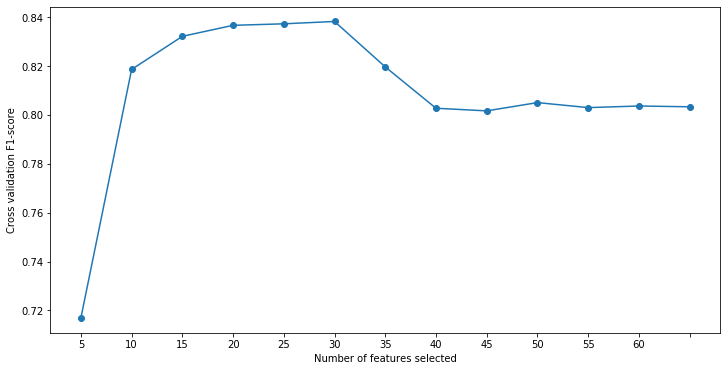

In [9]:
# Смотрим что получилось
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(x_train.shape[1], 1, -STEP))))
plt.show()

In [10]:
# Попробуем обучить XGBoost на этих признаках
X_train_RFE = pd.DataFrame(x_train_balanced, columns=X)[good_features]
X_test_RFE = pd.DataFrame(x_test, columns=X)[good_features]

In [27]:
fitted_clf = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

Precision: 0.1999708284714119
Recall: 0.6610414657666345
F1: 0.3070548712206047
Log Loss: 0.2088601821451638
ROC AUC: 0.9023581056278182


PL

In [16]:
%%time
fitted_clf = xgb_fit_predict(x_train_balanced, y_train_balanced, x_test, y_test)

Precision: 0.20671509042395494
Recall: 0.6723722275795564
F1: 0.31621315192743765
Log Loss: 0.20465001330166652
ROC AUC: 0.9088623135013674
CPU times: user 3min 6s, sys: 13.8 s, total: 3min 20s
Wall time: 1min 42s


Важные признаки на основе Permutation Importance

In [17]:
%%time
# Ранжируем признаки при помощи PermutationImportance
perm = PermutationImportance(fitted_clf, random_state=42).fit(x_train_balanced, y_train_balanced)
res = pd.DataFrame(X, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

CPU times: user 22min 9s, sys: 2min, total: 24min 10s
Wall time: 14min 46s


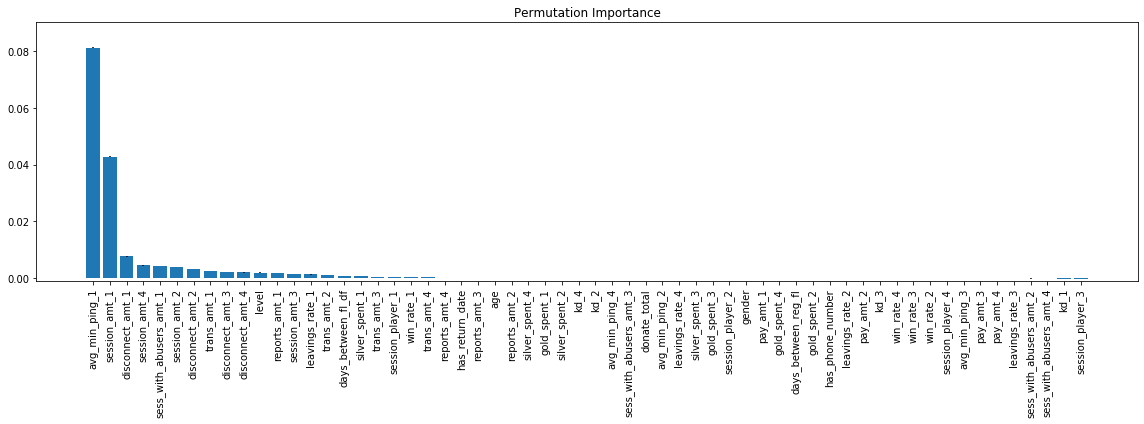

In [18]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.09)
plt.show()

In [19]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 39


In [20]:
X_train_PL = pd.DataFrame(x_train_balanced, columns=X)[good_features]
X_test_PL = pd.DataFrame(x_test, columns=X)[good_features]

In [34]:
fitted_clf = xgb_fit_predict(X_train_PL, y_train_balanced, X_test_PL, y_test)

Precision: 0.20209916757148028
Recall: 0.6730954676952748
F1: 0.3108612147191449
Log Loss: 0.210803885794664
ROC AUC: 0.907683287582887


Для модели XGBoost при Permutation Importance результат работы модели получается более точным, но не на много.
Следует помнить, что на большом кол-ве признаков модель работает дольше.

2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

Логистическая регрессия

In [39]:
model_lr = LogisticRegression()
model_lr.fit(X_train_RFE, y_train_balanced)

y_train_pred = model_lr.predict(X_train_RFE)
y_test_pred = model_lr.predict(X_test_RFE)

In [52]:
precision_test, recall_test, f1_test= evaluation(y_test, y_test_pred, y_train_pred)

Precision: 0.10574182163703
Recall: 0.7512054001928641
F1: 0.18538791051880057


In [53]:
model_lr = LogisticRegression()
model_lr.fit(X_train_PL, y_train_balanced)

y_train_pred = model_lr.predict(X_train_PL)
y_test_pred = model_lr.predict(X_test_PL)

In [54]:
precision_test, recall_test, f1_test= evaluation(y_test, y_test_pred, y_train_pred)

Precision: 0.07336399653900451
Recall: 0.7767598842815815
F1: 0.13406565971788792


CatBoost

In [ ]:
# model_knn = KNeighborsClassifier()
# model_knn.fit(X_train_RFE, y_train_balanced)

# y_train_pred = model_knn.predict(X_train_RFE)
# y_test_pred = model_knn.predict(X_test_RFE)

In [23]:
model_catb = catb.CatBoostClassifier(n_estimators=200, max_depth=3, 
                                     silent=True, random_state=42) 
model_catb.fit(X_train_RFE, y_train_balanced)

y_train_pred = model_catb.predict(X_train_RFE)
y_test_pred = model_catb.predict(X_test_RFE)

In [25]:
precision_test, recall_test, f1_test= evaluation_sec(y_test, y_test_pred, y_train_pred)

Precision: 0.2974701948240768
Recall: 0.4932497589199614
F1: 0.371122800653002


In [26]:
model_catb = catb.CatBoostClassifier(n_estimators=200, max_depth=3, 
                                     silent=True, random_state=42) 
model_catb.fit(X_train_PL, y_train_balanced)

y_train_pred = model_catb.predict(X_train_PL)
y_test_pred = model_catb.predict(X_test_PL)

In [27]:
precision_test, recall_test, f1_test= evaluation_sec(y_test, y_test_pred, y_train_pred)

Precision: 0.30294672666569894
Recall: 0.5031340405014465
F1: 0.3781824771224064


При использовании логистической регрессии качество модели снизилось, а при использовании CatBoost наоборот возрасло.

3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [36]:
corr = x_train_balanced.corr().round(2)
corr.style.background_gradient(cmap='coolwarm')

На основе матрицы корреляции я бы взял следующие признаки - 

[level, trans_amt_1, trans_amt_2, trans_amt_3, trans_amt_4,
reports_amt_1, session_amt_1, disconnect_amt_1, disconnect_amt_4,
avg_min_ping_1, session_player_1, win_rate_1, kd_1, kd_4,
leavings_rate_1, leavings_rate_4, 
gold_spent_1, gold_spent_2, gold_spent_3, gold_spent_4,
silver_spent_1, silver_spent_2, silver_spent_3, silver_spent_4,
age, gender, days_between_reg_fl, days_between_fl_df, has_return_date,
has_phone_number]